In [1]:
import pathpy as pp
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
import time
import warnings
import pickle
import sys
import neptune

warnings.filterwarnings('ignore')

In [2]:
# add paths for modules
sys.path.append('../src/models')
sys.path.append('../src/features')
sys.path.append('../src/visualization')

from maritime_traffic_network import MaritimeTrafficNetwork
from MOGen_path_prediction import MOGenPathPrediction
from dijkstra_path_prediction import DijkstraPathPrediction
import prediction_model_evaluation_metrics as metrics

In [3]:
# Experiment parameters
datasize = 'full'
location = 'tromso'
network_date = '202204'
train_dates = ['202204', '202205']
test_dates = ['202206']
DP_tol = 10
min_samples = 13

In [4]:
# Load a network model from pickle
network_name = network_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
network_path = '../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [5]:
# Load training data for prediction model
for i in range(0, len(train_dates)):
    train_date = train_dates[i]
    filename = network_name+'_'+train_date+'_paths.csv'
    training_data = pd.read_csv('../data/paths/'+filename)
    training_data['path'] = training_data['path'].apply(literal_eval)
    training_data = gpd.GeoDataFrame(training_data, geometry=gpd.GeoSeries.from_wkt(training_data['geometry']), crs=network.crs)
    training_data = training_data[training_data['message']=='success']
    if i==0:
        all_training_data = training_data
    else:
        all_training_data = pd.concat([all_training_data, training_data])
# extract paths from the training data
training_paths = all_training_data['path'].tolist()

In [6]:
# Load test data for prediction model
for i in range(0, len(test_dates)):
    test_date = test_dates[i]
    # Load path data
    filename = network_name+'_'+test_date+'_paths.csv'
    test_data = pd.read_csv('../data/paths/'+filename)
    test_data['path'] = test_data['path'].apply(literal_eval)
    test_data = gpd.GeoDataFrame(test_data, geometry=gpd.GeoSeries.from_wkt(test_data['geometry']), crs=network.crs)
    test_data = test_data[test_data['message']=='success']

    # Load respective trajectories for evaluation
    traj_file = test_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
    filename = '../data/processed/' + traj_file + '.parquet'
    traj_gdf = gpd.read_parquet(filename)
    traj_gdf.to_crs(network.crs, inplace=True)  # Transformation
    
    if i==0:
        all_test_data = test_data
        all_traj_gdf = traj_gdf
    else:
        all_test_data = pd.concat([all_test_data, test_data])
        all_traj_gdf = pd.concat([all_traj_gdf, traj_gdf])
        
test_trajectories = mpd.TrajectoryCollection(all_traj_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

In [7]:
# select test data
selection_start = 0
selection_end = len(test_data)
selection_step = 2
selection = np.arange(selection_start, selection_end, selection_step)
n_test_paths = len(selection)
test_paths = all_test_data.iloc[selection]

https://app.neptune.ai/jandrik91/RoutePredictions/e/ROUT-65
Evaluating Dijkstra model on 761 samples for path prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 28352974.24 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 275.31m
Median SSPD: 44.13m


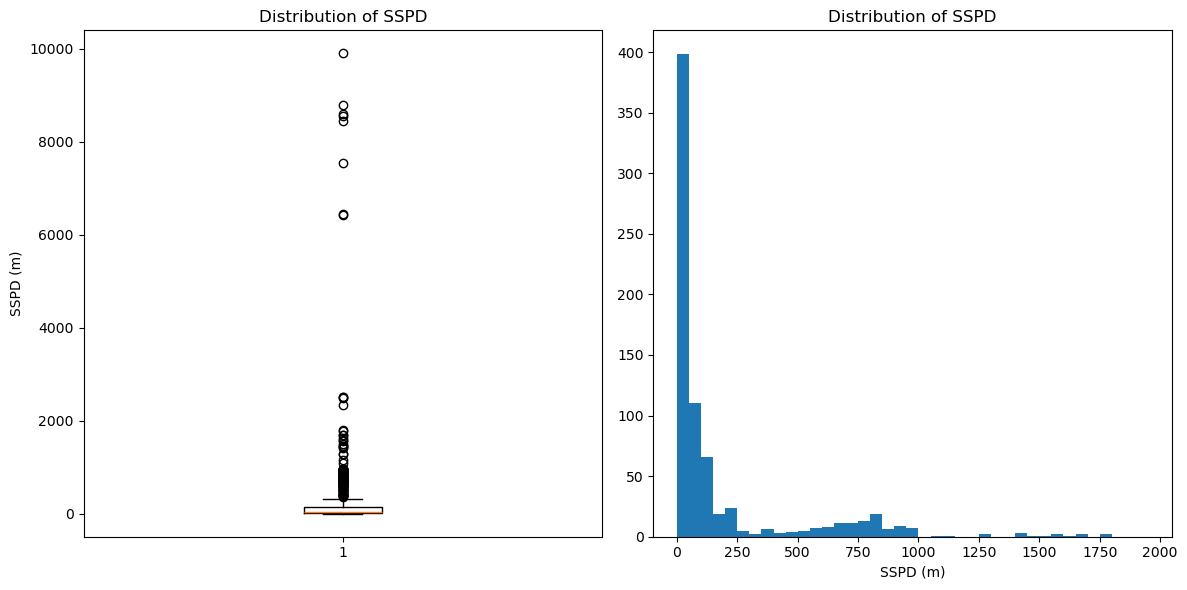

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 34 operations to synchronize with Neptune. Do not kill this process.
All 34 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jandrik91/RoutePredictions/e/ROUT-65/metadata


In [8]:
# make experiments
prediction_task = 'path'
eval_mode = 'path'
model_type = 'Dijkstra'
vals_n_walks = [0] #[1000, 500, 200, 1000, 500, 200, 1000, 500, 200]
vals_max_order = [0]
MOGen_training_mode = 'partial'
vals_n_start_nodes = [1]

for i in range (0, len(vals_n_walks)):
    run = neptune.init_run(
        project="jandrik91/RoutePredictions",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",
    )  # your credentials

    # train model
    MOGen_n_walks = vals_n_walks[i]
    MOGen_max_order = vals_max_order[i]
    n_start_nodes = vals_n_start_nodes[i]
    model = DijkstraPathPrediction()
    model.train(network.G_pruned, training_paths)
    #model = MOGenPathPrediction()
    #model.train(training_paths, max_order=MOGen_max_order, model_selection=True, training_mode=MOGen_training_mode)
    
    # evaluate
    evaluation_results, fig = metrics.evaluate(model, prediction_task, test_paths, test_trajectories, network, n_start_nodes=n_start_nodes,
                                               MOGen_n_walks=MOGen_n_walks, eval_mode=eval_mode)
    nan_mask = evaluation_results.isna().any(axis=1)
    failure_rate = nan_mask.sum() / len(evaluation_results)
    mean_abs_err = np.mean(evaluation_results[~nan_mask]["SSPD"])
    median_abs_err = np.median(evaluation_results[~nan_mask]["SSPD"])

    # save experiment
    run["network_name"] = network_name
    run["n_points"]=len(network.gdf)
    run["n_nodes"]=network.G.number_of_nodes()
    run["n_edges"]=network.G.number_of_edges()
    
    params = network.hyperparameters
    params['clustering_metric_V_coord'] = params['clustering_metric_V'][0][0]
    params['clustering_metric_V_cog'] = params['clustering_metric_V'][2][2]
    params['clustering_metric_V_speed'] = params['clustering_metric_V'][4][4]
    run["network_parameters"] = params
    
    run["training_data"] = {'training_dates':str(train_dates),
                            'n_training_paths':len(training_paths)}
    
    run["test_data"] = {'test_dates':str(test_dates),
                        'selection_start':selection_start,
                        'selection_end':selection_end,
                        'selection_step':selection_step,
                        'n_test_paths':n_test_paths}
    
    run["prediction_task"] = prediction_task
    run["eval_mode"] = eval_mode
    run["model_type"] = model_type
    run["MOGen_n_walks"] = MOGen_n_walks
    run["MOGen_max_order"] = MOGen_max_order
    run["MOGen_training_mode"] = MOGen_training_mode
    run["n_start_nodes"] = n_start_nodes
    
    run["plot"].upload(fig)
    run["failure_rate"] = failure_rate
    run["mean_abs_err"] = mean_abs_err
    run["median_abs_err"] = median_abs_err
    
    run.stop()